# Imports

In [106]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from mplsoccer import Pitch

# Constants

In [107]:
GOAL_CENTER_X = 100
GOAL_CENTER_Y = 50

# Data Exploration

## Basic Info

In [108]:
xg_raw_data_df = pd.read_csv('xg_model.csv')

In [109]:
xg_raw_data_df.shape

(8118, 25)

In [110]:
xg_raw_data_df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OwnGoal,OtherBodyPart,DirectCorner
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79.3,24.2,False,SecondHalf,True,Center,True,True,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.0,59.5,False,SecondHalf,True,Center,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89.8,55.6,False,SecondHalf,True,Center,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84.9,56.2,False,SecondHalf,True,Center,NaN,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
xg_raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8118 entries, 0 to 8117
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   x                8118 non-null   float64
 1   y                8118 non-null   float64
 2   is_goal          8118 non-null   bool   
 3   period           8118 non-null   object 
 4   Assisted         6038 non-null   object 
 5   Zone             8118 non-null   object 
 6   IndividualPlay   2802 non-null   object 
 7   RegularPlay      5390 non-null   object 
 8   LeftFoot         2791 non-null   object 
 9   RightFoot        3994 non-null   object 
 10  FromCorner       1194 non-null   object 
 11  FirstTouch       3925 non-null   object 
 12  Head             1300 non-null   object 
 13  BigChance        1607 non-null   object 
 14  SetPiece         393 non-null    object 
 15  Volley           810 non-null    object 
 16  FastBreak        616 non-null    object 
 17  ThrowinSetPiec

In [112]:
xg_raw_data_df['Penalty'].value_counts()

Penalty
True    106
Name: count, dtype: int64

In [113]:
xg_raw_data_df['OwnGoal'].value_counts()

OwnGoal
True    27
Name: count, dtype: int64

In [114]:
xg_raw_data_df.x.max(), xg_raw_data_df.x.min()

(np.float64(99.6), np.float64(0.8))

In [115]:
xg_raw_data_df.y.max(), xg_raw_data_df.y.min()

(np.float64(99.6), np.float64(3.1))

In [116]:
xg_raw_data_df.columns.to_list()

['x',
 'y',
 'is_goal',
 'period',
 'Assisted',
 'Zone',
 'IndividualPlay',
 'RegularPlay',
 'LeftFoot',
 'RightFoot',
 'FromCorner',
 'FirstTouch',
 'Head',
 'BigChance',
 'SetPiece',
 'Volley',
 'FastBreak',
 'ThrowinSetPiece',
 'Penalty',
 'OneOnOne',
 'KeyPass',
 'DirectFreekick',
 'OwnGoal',
 'OtherBodyPart',
 'DirectCorner']

## Removing Own Goals

In [117]:
xg_raw_data_df = xg_raw_data_df[xg_raw_data_df['OwnGoal'] != True]
xg_raw_data_df.drop(columns='OwnGoal', inplace=True)

In [118]:
xg_raw_data_df.shape

(8091, 24)

## Filling Null Data

In [119]:
xg_raw_data_df.isna().sum()

x                     0
y                     0
is_goal               0
period                0
Assisted           2053
Zone                  0
IndividualPlay     5289
RegularPlay        2714
LeftFoot           5307
RightFoot          4106
FromCorner         6903
FirstTouch         4166
Head               6793
BigChance          6484
SetPiece           7704
Volley             7281
FastBreak          7476
ThrowinSetPiece    7904
Penalty            7985
OneOnOne           7890
KeyPass            8033
DirectFreekick     7860
OtherBodyPart      8067
DirectCorner       8089
dtype: int64

In [120]:
xg_raw_data_df.fillna(False, inplace=True);

/tmp/ipykernel_96483/821668648.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xg_raw_data_df.fillna(False, inplace=True);


In [121]:
xg_raw_data_df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,SetPiece,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,79.3,24.2,False,SecondHalf,True,Center,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,80.0,59.5,False,SecondHalf,True,Center,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,89.8,55.6,False,SecondHalf,True,Center,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,84.9,56.2,False,SecondHalf,True,Center,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [187]:
xg_raw_data_df['Penalty'].value_counts()

Penalty
False    7914
True      106
Name: count, dtype: int64

## Scatter Plot

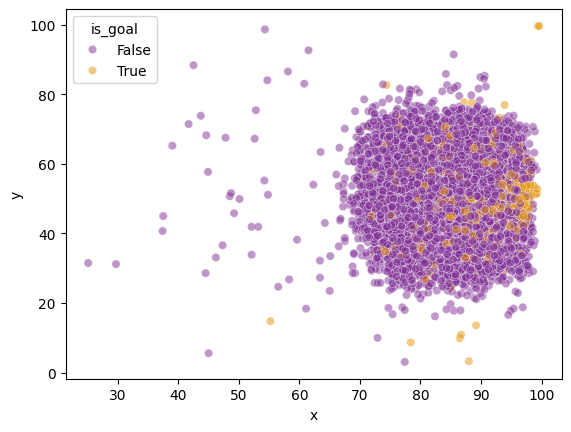

In [122]:
sns.scatterplot(x='x', y='y', data=xg_raw_data_df, alpha=0.5, hue='is_goal', palette='CMRmap');

## Dtypes

In [123]:
xg_raw_data_df.dtypes

x                  float64
y                  float64
is_goal               bool
period              object
Assisted              bool
Zone                object
IndividualPlay        bool
RegularPlay           bool
LeftFoot              bool
RightFoot             bool
FromCorner            bool
FirstTouch            bool
Head                  bool
BigChance             bool
SetPiece              bool
Volley                bool
FastBreak             bool
ThrowinSetPiece       bool
Penalty               bool
OneOnOne              bool
KeyPass               bool
DirectFreekick        bool
OtherBodyPart         bool
DirectCorner          bool
dtype: object

In [124]:
xg_raw_data_df['period'].value_counts()

period
SecondHalf    4333
FirstHalf     3758
Name: count, dtype: int64

In [125]:
xg_raw_data_df['Zone'].value_counts()

Zone
Center    8020
Left        30
Right       23
Back        18
Name: count, dtype: int64

In [126]:
xg_raw_data_df['firstHalf'] = xg_raw_data_df['period'].apply(lambda x: False if x == 'SecondHalf' else True)

In [127]:
xg_raw_data_df.drop(columns=['period'], inplace=True)

In [128]:
xg_raw_data_df.head()

,x,y,is_goal,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf
0,80.8,51.6,False,True,Center,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,79.3,24.2,False,True,Center,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,80.0,59.5,False,True,Center,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,89.8,55.6,False,True,Center,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,84.9,56.2,False,True,Center,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [129]:
xg_raw_data_df = xg_raw_data_df[xg_raw_data_df['Zone'] == 'Center']
xg_raw_data_df.drop(columns=['Zone'], inplace=True)

In [130]:
xg_raw_data_df.head()

,x,y,is_goal,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf
0,80.8,51.6,False,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,79.3,24.2,False,True,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,80.0,59.5,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,89.8,55.6,False,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,84.9,56.2,False,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [131]:
xg_raw_data_df.shape

(8020, 23)

In [132]:
xg_data_pre_eng_df = xg_raw_data_df.copy()

# Feature Engineering

In [133]:
xg_data_pre_eng_df["shot_distance"] = xg_data_pre_eng_df.apply(
    lambda row: np.sqrt((row["x"] - GOAL_CENTER_X) ** 2 + (row["y"] - GOAL_CENTER_Y) ** 2), axis=1
)

In [134]:
xg_data_pre_eng_df.head()

,x,y,is_goal,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,...,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf,shot_distance
0,80.8,51.6,False,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,19.266551
1,79.3,24.2,False,True,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,33.077636
2,80.0,59.5,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,22.141590
3,89.8,55.6,False,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,11.636151
4,84.9,56.2,False,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,16.323296


In [135]:
xg_data_pre_eng_df["shot_distance"].describe()

count    8020.000000
mean       18.253831
std         7.541987
min         1.581139
25%        12.020815
50%        18.264994
75%        24.001250
max        53.600373
Name: shot_distance, dtype: float64

<Axes: >

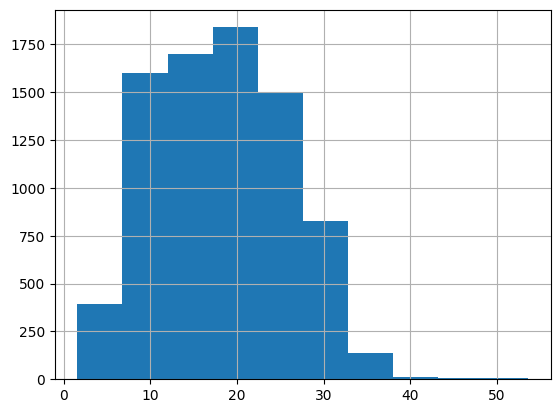

In [136]:
xg_data_pre_eng_df["shot_distance"].hist()

In [137]:
xg_data_df = xg_data_pre_eng_df.copy()

# Split Data

In [138]:
X = xg_data_df.drop(columns=['is_goal'], axis=1)
y = xg_data_df['is_goal']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Data

## Logicstic Regression

In [140]:
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [141]:
y_pred_proba = model_log.predict_proba(X_test)[:, 1]

In [142]:
y_pred_proba

array([0.05257932, 0.06409953, 0.02637418, ..., 0.0492199 , 0.06147119,
       0.46007289], shape=(1604,))

In [143]:
y_pred_proba[:10]

array([0.05257932, 0.06409953, 0.02637418, 0.03214933, 0.04286213,
       0.05729975, 0.08470142, 0.04862529, 0.0241581 , 0.22310609])

In [144]:
final_df_log = X_test.copy()
final_df_log['xG'] = y_pred_proba

In [145]:
final_df_log.iloc[830]

x                      98.2
y                      56.5
Assisted               True
IndividualPlay        False
RegularPlay           False
LeftFoot              False
RightFoot             False
FromCorner             True
FirstTouch             True
Head                  False
BigChance              True
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty               False
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart          True
DirectCorner          False
firstHalf             False
shot_distance      6.744627
xG                 0.342529
Name: 1639, dtype: object

In [146]:
final_df_log.iloc[28]

x                      91.0
y                      34.6
Assisted               True
IndividualPlay         True
RegularPlay            True
LeftFoot               True
RightFoot             False
FromCorner            False
FirstTouch            False
Head                  False
BigChance             False
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty               False
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart         False
DirectCorner          False
firstHalf              True
shot_distance      17.83704
xG                 0.075646
Name: 1614, dtype: object

In [147]:
final_df_log.sort_values(by='xG', ascending=False).head()

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf,shot_distance,xG
50,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.808865
4957,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.808865
3769,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.808865
7521,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.808865
4133,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.808865


In [148]:
log_loss(y_test, y_pred_proba)

0.26823460587866876

In [149]:
roc_auc_score(y_test, y_pred_proba)

0.8334941200665582

In [150]:
brier_score_loss(y_test, y_pred_proba)

0.0774885180927491

In [151]:
pitch = Pitch(pitch_type='opta')
colors = ['red', 'yellow', 'green']
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

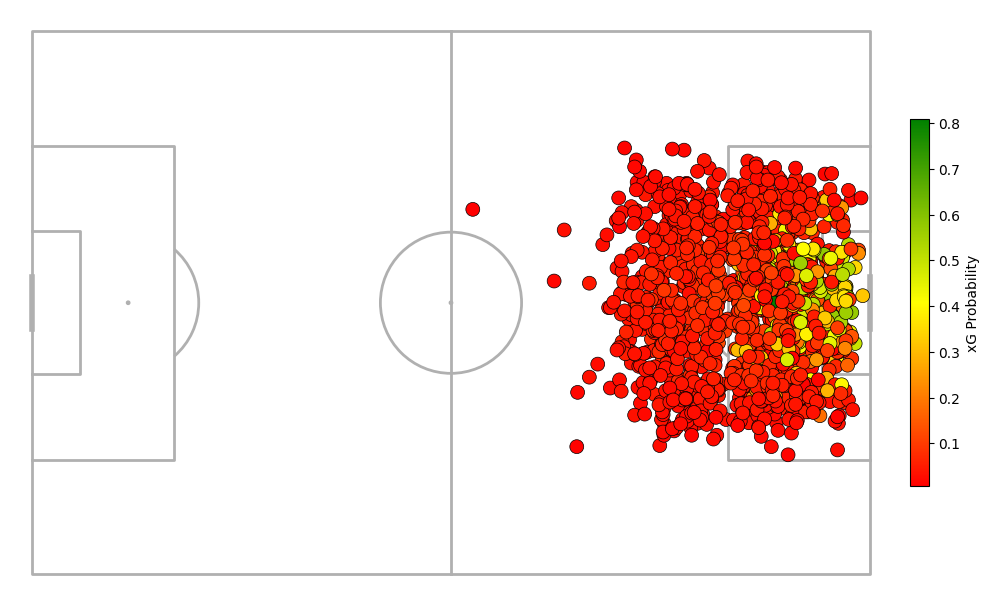

In [152]:
fig, ax = pitch.draw(figsize=(10,8))

sc = pitch.scatter(
    final_df_log['x'], 
    final_df_log['y'], 
    c=final_df_log['xG'],
    cmap=cmap,
    edgecolor='black',
    linewidth=.5,
    s=100,
    ax=ax
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=.02, pad=.02)
cbar.set_label('xG Probability')

## xG Boost

In [153]:
param_grid = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_base = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

In [154]:
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.1

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [200, 500, ...], 'subsample': [0.7, 0.8, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [155]:
model_xg = grid_search.best_estimator_

In [156]:
y_pred_proba = model_xg.predict_proba(X_test)[:, 1]

In [157]:
y_pred_proba

array([0.06450705, 0.07230234, 0.03794813, ..., 0.04700236, 0.07651036,
       0.3540383 ], shape=(1604,), dtype=float32)

In [158]:
y_pred_proba[:10]

array([0.06450705, 0.07230234, 0.03794813, 0.05129613, 0.05820543,
       0.0465337 , 0.0607248 , 0.07276278, 0.05810734, 0.28831524],
      dtype=float32)

In [159]:
final_df_xg = X_test.copy()
final_df_xg['xG'] = y_pred_proba

In [160]:
final_df_xg.iloc[830]

x                      98.2
y                      56.5
Assisted               True
IndividualPlay        False
RegularPlay           False
LeftFoot              False
RightFoot             False
FromCorner             True
FirstTouch             True
Head                  False
BigChance              True
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty               False
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart          True
DirectCorner          False
firstHalf             False
shot_distance      6.744627
xG                 0.406195
Name: 1639, dtype: object

In [161]:
final_df_xg.iloc[28]

x                      91.0
y                      34.6
Assisted               True
IndividualPlay         True
RegularPlay            True
LeftFoot               True
RightFoot             False
FromCorner            False
FirstTouch            False
Head                  False
BigChance             False
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty               False
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart         False
DirectCorner          False
firstHalf              True
shot_distance      17.83704
xG                 0.061083
Name: 1614, dtype: object

In [162]:
final_df_xg.sort_values(by='xG', ascending=False).head()

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf,shot_distance,xG
6619,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.771996
3671,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.771996
7067,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.771996
7504,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.771996
704,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.771996


In [163]:
log_loss(y_test, y_pred_proba)

0.2668557159802206

In [164]:
roc_auc_score(y_test, y_pred_proba)

0.8326453156841849

In [165]:
brier_score_loss(y_test, y_pred_proba)

0.07660539426041243

In [166]:
pitch = Pitch(pitch_type='opta')
colors = ['red', 'yellow', 'green']
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

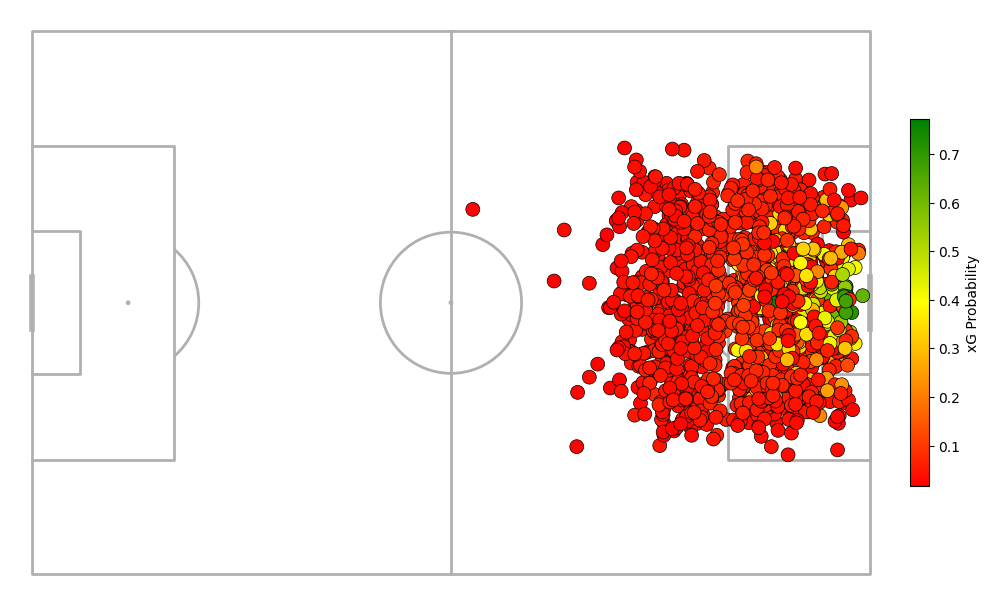

In [167]:
fig, ax = pitch.draw(figsize=(10,8))

sc = pitch.scatter(
    final_df_xg['x'], 
    final_df_xg['y'], 
    c=final_df_xg['xG'],
    cmap=cmap,
    edgecolor='black',
    linewidth=.5,
    s=100,
    ax=ax
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=.02, pad=.02)
cbar.set_label('xG Probability')

## Random Forest Classifier

In [168]:
param_grid = {
    'max_depth': [3,5,10],
    'n_estimators': [100, 300, 500],
    'max_features': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

random_forest_base = RandomForestClassifier()

In [169]:
grid_search = GridSearchCV(
    estimator=random_forest_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=300; total time=   0.6s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=300; total time=   0.6s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=300; total time=   0.6s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=500; total time=   1.0s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=500; total time=   1.0s
[CV] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=500; total time=   1.0s
[CV] END max_depth=3, max_features=10, min_samples_leaf=2, n_estimators=10

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [3, 5, ...], 'max_features': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [170]:
model_rf = grid_search.best_estimator_

In [171]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [172]:
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

In [173]:
y_pred_proba

array([0.06600157, 0.05826348, 0.0409856 , ..., 0.0417797 , 0.07101321,
       0.33438847], shape=(1604,))

In [174]:
y_pred_proba[:10]

array([0.06600157, 0.05826348, 0.0409856 , 0.04909524, 0.05294042,
       0.0481211 , 0.0541971 , 0.07305548, 0.05179082, 0.27138761])

In [175]:
final_df_rf = X_test.copy()
final_df_rf['xG'] = y_pred_proba

In [176]:
final_df_rf.iloc[830]

x                      98.2
y                      56.5
Assisted               True
IndividualPlay        False
RegularPlay           False
LeftFoot              False
RightFoot             False
FromCorner             True
FirstTouch             True
Head                  False
BigChance              True
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty               False
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart          True
DirectCorner          False
firstHalf             False
shot_distance      6.744627
xG                 0.423866
Name: 1639, dtype: object

In [177]:
final_df_rf.iloc[28]

x                      91.0
y                      34.6
Assisted               True
IndividualPlay         True
RegularPlay            True
LeftFoot               True
RightFoot             False
FromCorner            False
FirstTouch            False
Head                  False
BigChance             False
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty               False
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart         False
DirectCorner          False
firstHalf              True
shot_distance      17.83704
xG                 0.063661
Name: 1614, dtype: object

In [178]:
final_df_rf.sort_values(by='xG', ascending=False).head()

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf,shot_distance,xG
498,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,True,11.5,0.837085
50,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.817486
4957,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.817486
7521,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.817486
3769,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.5,0.817486


In [189]:
final_df_rf.sort_values(by='xG', ascending=False).head(30)

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,firstHalf,shot_distance,xG
498,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,True,11.500000,0.837085
50,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.817486
4957,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.817486
7521,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.817486
3769,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.817486
4133,88.5,50.0,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.817486
7067,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.795321
6619,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.795321
704,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.795321
7196,88.5,50.0,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,11.500000,0.795321


In [179]:
final_df_rf.sort_values(by='xG', ascending=False).iloc[0]

x                      88.5
y                      50.0
Assisted              False
IndividualPlay        False
RegularPlay           False
LeftFoot               True
RightFoot             False
FromCorner            False
FirstTouch            False
Head                  False
BigChance              True
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty                True
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart         False
DirectCorner          False
firstHalf              True
shot_distance          11.5
xG                 0.837085
Name: 498, dtype: object

In [180]:
final_df_rf.sort_values(by='xG', ascending=False).iloc[1]

x                      88.5
y                      50.0
Assisted              False
IndividualPlay        False
RegularPlay           False
LeftFoot              False
RightFoot              True
FromCorner            False
FirstTouch            False
Head                  False
BigChance              True
SetPiece              False
Volley                False
FastBreak             False
ThrowinSetPiece       False
Penalty                True
OneOnOne              False
KeyPass               False
DirectFreekick        False
OtherBodyPart         False
DirectCorner          False
firstHalf             False
shot_distance          11.5
xG                 0.817486
Name: 50, dtype: object

In [181]:
log_loss(y_test, y_pred_proba)

0.2668197774403566

In [182]:
roc_auc_score(y_test, y_pred_proba)

0.8334043786340606

In [183]:
brier_score_loss(y_test, y_pred_proba)

0.07632020378969726

In [184]:
pitch = Pitch(pitch_type='opta')
colors = ['red', 'yellow', 'green']
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

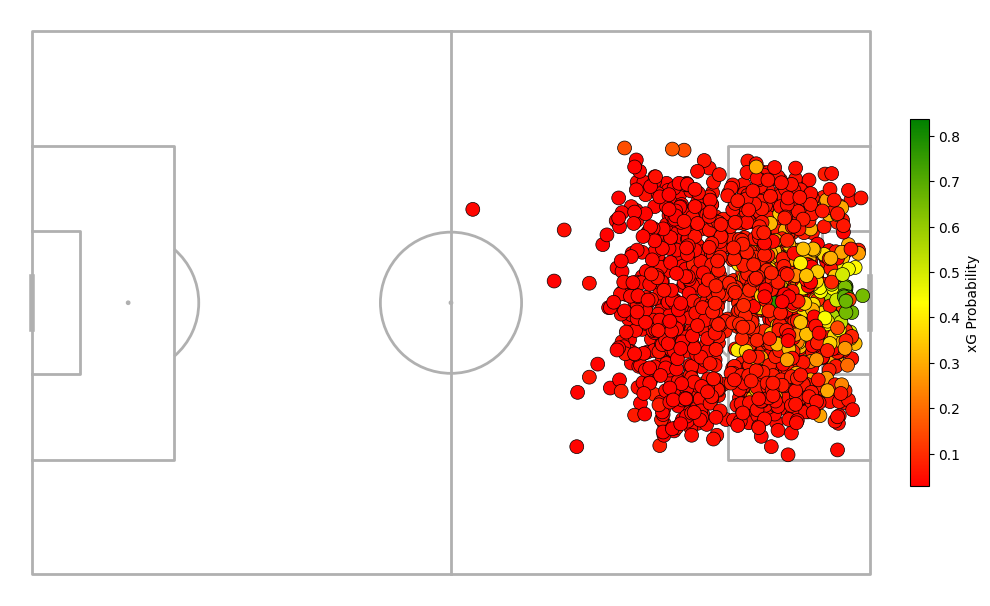

In [185]:
fig, ax = pitch.draw(figsize=(10,8))

sc = pitch.scatter(
    final_df_rf['x'], 
    final_df_rf['y'], 
    c=final_df_rf['xG'],
    cmap=cmap,
    edgecolor='black',
    linewidth=.5,
    s=100,
    ax=ax
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=.02, pad=.02)
cbar.set_label('xG Probability')